In [3]:
import gym
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

In [36]:
env = gym.make('CartPole-v0')
n_episodes = 5000
max_step = 1000

In [37]:
device = 'cuda:0'
policy_net = nn.Sequential(
                    #nn.Linear(128, 128),
                    #nn.LeakyReLU(0.01),
                    nn.Linear(4, 64),
                    nn.LeakyReLU(0.01),
                    nn.Linear(64, 2),
                    nn.Softmax()
                    )
policy_net.to(device)
policy_optimizer = torch.optim.Adam(policy_net.parameters(), lr=3e-3)
policy_scheduler = torch.optim.lr_scheduler.StepLR(policy_optimizer, 5, gamma=0.95)

critic_net = nn.Sequential(
                    #nn.Linear(128, 128),
                    #nn.LeakyReLU(0.01),
                    nn.Linear(4, 64),
                    nn.LeakyReLU(0.01),
                    nn.Linear(64, 1)
                    )
critic_net.to(device)
critic_optimizer = torch.optim.Adam(critic_net.parameters(), lr=3e-3)
critic_scheduler = torch.optim.lr_scheduler.StepLR(critic_optimizer, 5, gamma=0.95)

In [38]:
total_rewards = []
freq = max(n_episodes // 20, 1)

In [39]:
eps = 0.0001

In [40]:
for episode in range(n_episodes):
    logs = []
    rewards = []
    values = []
    state = torch.tensor(env.reset(), dtype=torch.float32).to(device)
    for step in range(max_step):
        policy = policy_net(state)
        q = np.random.choice(np.arange(2), p=[eps, 1 - eps])
        if q:
            action = np.random.choice(np.arange(2), p=policy.cpu().detach().numpy())
        else:
            action = np.random.randint(2)
        log = torch.log(policy[action] + 1e-6)
        logs.append(log)
        value = critic_net(state)
        values.append(value)
        state, reward, done, info = env.step(action)
        state = torch.tensor(state, dtype=torch.float32).to(device)
        rewards.append(reward)
        if done:
            break
    T = len(rewards)
    #print(rewards[-1])
    total_rewards.append(np.sum(rewards))
    values.append(torch.tensor([0], dtype=torch.float32))
    G = []
    for t in range(T):
        g = rewards[t] + values[t + 1].cpu().detach().numpy()[0] - values[t].cpu().detach().numpy()[0]
        G.append(g)
        
    log_grads = 0
    for log, g in zip(logs, G):
        log_grads -= g * log
        
    value_grads = 0
    for value, g in zip(values, G):
        value_grads -= g * value
    
    policy_optimizer.zero_grad()
    log_grads.to(device).backward(retain_graph=True)
    policy_optimizer.step()
    policy_scheduler.step()
    
    critic_optimizer.zero_grad()
    value_grads.to(device).backward()
    critic_optimizer.step()
    critic_scheduler.step()
    
    if not episode % freq:
        print('Episode: {}/{} || Reward: {}  Steps: {}'.format(episode, n_episodes, total_rewards[-1], T))
        print('log grad:', log_grads)
        print('value grad', value_grads, end='\n\n')

Episode: 0/5000 || Reward: 35.0  Steps: 35
log grad: tensor(24.0564, device='cuda:0', grad_fn=<SubBackward0>)
value grad tensor([-6.2765], device='cuda:0', grad_fn=<SubBackward0>)

Episode: 250/5000 || Reward: 10.0  Steps: 10
log grad: tensor(2.4448, device='cuda:0', grad_fn=<SubBackward0>)
value grad tensor([-23.9234], device='cuda:0', grad_fn=<SubBackward0>)

Episode: 500/5000 || Reward: 11.0  Steps: 11
log grad: tensor(3.3496, device='cuda:0', grad_fn=<SubBackward0>)
value grad tensor([-30.9956], device='cuda:0', grad_fn=<SubBackward0>)

Episode: 750/5000 || Reward: 10.0  Steps: 10
log grad: tensor(0.2246, device='cuda:0', grad_fn=<SubBackward0>)
value grad tensor([-25.8212], device='cuda:0', grad_fn=<SubBackward0>)

Episode: 1000/5000 || Reward: 8.0  Steps: 8
log grad: tensor(0.1911, device='cuda:0', grad_fn=<SubBackward0>)
value grad tensor([-15.5378], device='cuda:0', grad_fn=<SubBackward0>)

Episode: 1250/5000 || Reward: 9.0  Steps: 9
log grad: tensor(0.2054, device='cuda:0', gr

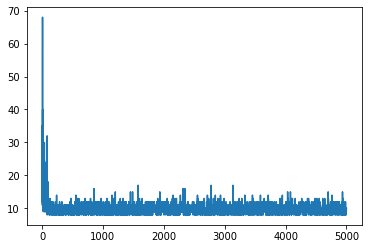

In [41]:
plt.plot(total_rewards);

In [42]:
np.mean(total_rewards)

9.7698